In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import local_acq, phase_ucb_acq, generate, likelihood

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [3]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

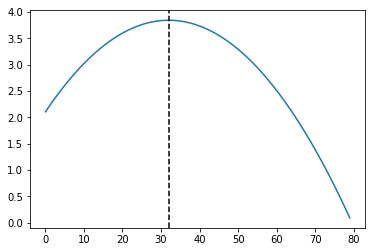

In [4]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [5]:
learning_rate_params = [0, 0, 350]
stay_penalty_params = [1, 0, 0]
temp_params = [.0001, .001, .01]
trials = np.arange(20)
titles = ['Stay', 'Local Search', 'Gradient Ascent']

In [6]:
data = [[generate(local_acq, {'learning_rate': [learning_rate_params[i]], 'stay_penalty': [stay_penalty_params[i]], 'temperature': [temp_params[j]]},
        neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0] for i in range(len(learning_rate_params))] for j in range(len(temp_params))]

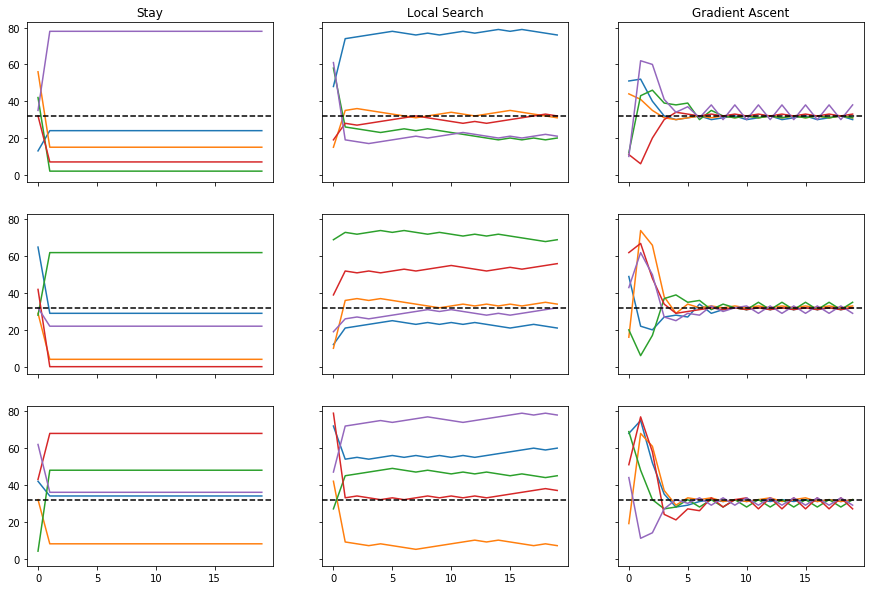

In [7]:

fig, axes = plt.subplots(len(temp_params), len(learning_rate_params), sharex=True, sharey=True, figsize=(15,10))
for j in range(len(temp_params)):
    for i in range(len(learning_rate_params)):
        actions = data[j][i][:,:,5].argmax(axis=2)
        axes[j][i].plot(actions[:5].T);
        axes[j][i].axhline(y=fmax, ls='--', c='black');
        if j == 0:
            axes[j][i].set_title(titles[i])

## Stay

In [8]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 1., 1., shape=1)
    stay_penalty = pm.Beta('stay_penalty', 2, .01, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][0], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    stay_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:25<00:00, 108.28draws/s]
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7025894785867828, but should be close to 0.8. Try to increase the number of tuning steps.
There were 144 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


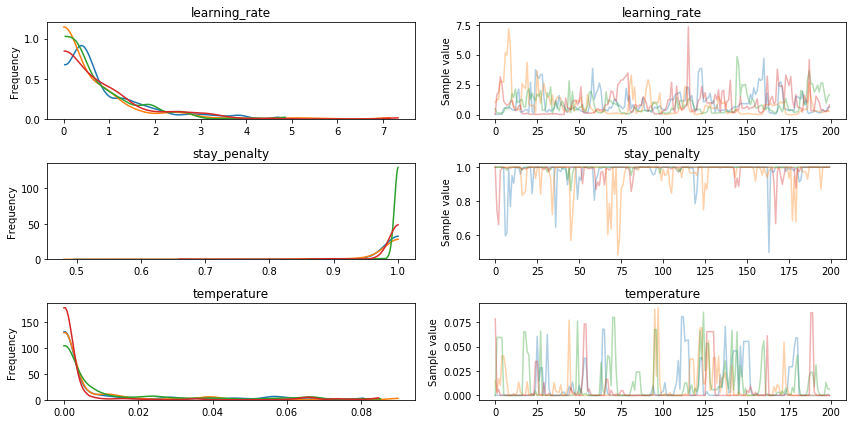

In [9]:
pm.traceplot(stay_trace);

## Local Search

In [10]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 1., 1., shape=1)
    stay_penalty = pm.Beta('stay_penalty', 2, .01, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][1], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    local_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:25<00:00, 111.58draws/s]
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7052852709700024, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


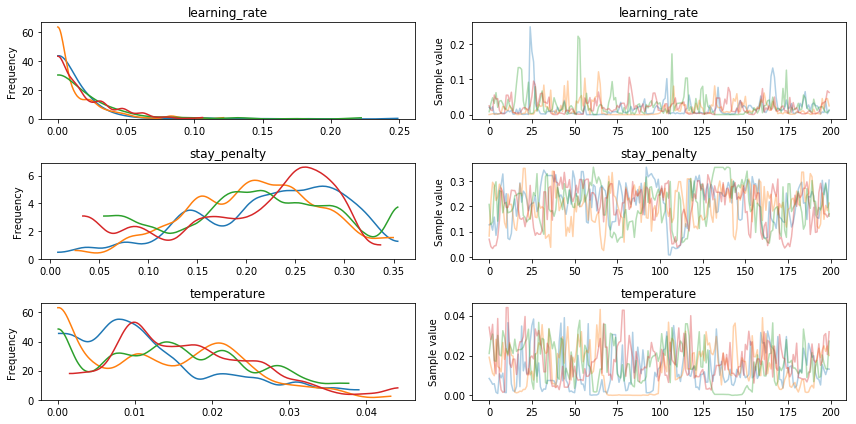

In [11]:
pm.traceplot(local_trace);

## Gradient Ascent

#### Learning Rate Prior

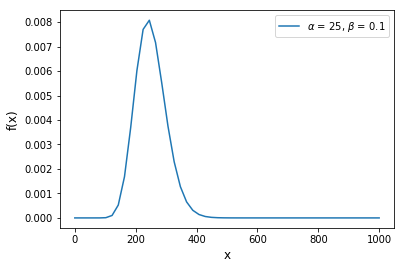

In [12]:
x = np.linspace(0, 1000)
alphas = [25]
betas = [.1]
for a, b in zip(alphas, betas):
    pdf = st.gamma.pdf(x, a, scale=1.0/b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [13]:
with pm.Model() as model:
    learning_rate = pm.Gamma('learning_rate', 25., .1, shape=1)
    stay_penalty = pm.Beta('stay_penalty', 1, 1, shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][2], local_acq, {'learning_rate': learning_rate, 
                               'temperature': temperature, 'stay_penalty': stay_penalty}, 1, [1.]))
    gradient_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, stay_penalty, learning_rate]
Sampling 4 chains: 100%|██████████| 2800/2800 [00:52<00:00, 53.08draws/s] 
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
There were 145 divergences after tuning. Increase `target_accept` or reparameterize.
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
There were 143 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


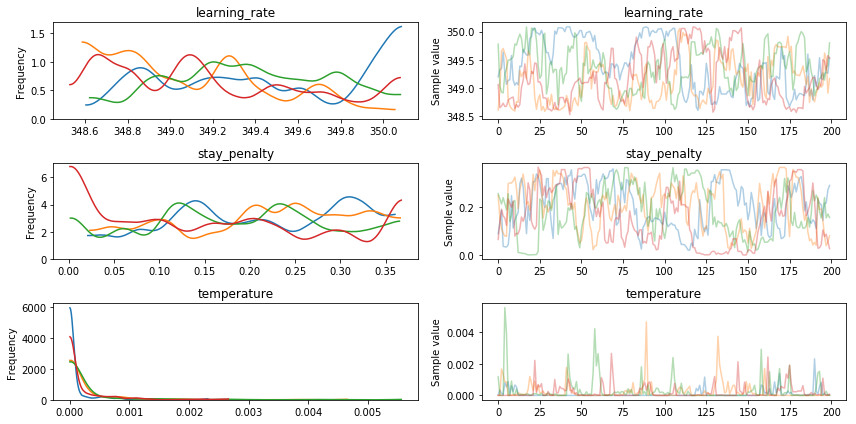

In [14]:
pm.traceplot(gradient_trace);